## Run pretrained model with pytorch video
https://pytorchvideo.org/docs/tutorial_torchhub_inference

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Final Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load pretrained model

YOLOv5 https://pytorch.org/hub/ultralytics_yolov5/

In [ ]:
# install YOLO5 dependencies
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

SyntaxError: ignored

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)
# Set to eval mode and move to desired device
model = model.to(DEVICE)
model = model.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-7-5 Python-3.7.13 torch-1.12.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


## example inference with one image

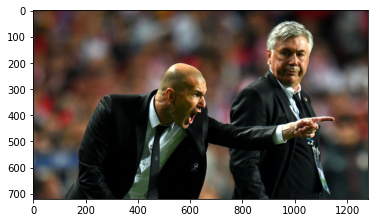

In [ ]:
from PIL import Image
import requests

url = 'https://ultralytics.com/images/zidane.jpg'
im=Image.open(requests.get(url, stream=True).raw)
plt.imshow(im)
plt.show()

In [ ]:
# Image
from PIL import Image
url = 'https://ultralytics.com/images/zidane.jpg'
im1 = Image.open('test_images/1.JPG') 
im2 = Image.open('test_images/2.jpg') 
im3 = Image.open('test_images/3.JPG') 
results = model([im1,im2,im3])
results.print()
results.display(save=True) # saves the image

image 1/3: 3024x4032 14 persons, 1 truck, 2 backpacks, 4 umbrellas, 4 handbags, 1 cell phone
image 2/3: 854x480 1 person
image 3/3: 2736x3648 (no detections)
Speed: 218.1ms pre-process, 13.3ms inference, 19.0ms NMS per image at shape (3, 3, 640, 640)


Saved 3 images to .


In [ ]:
from PIL import Image
import requests
import numpy as np
im=Image.open(requests.get(url, stream=True).raw)
def exif_transpose(image):
    """
    Transpose a PIL image accordingly if it has an EXIF Orientation tag.
    Inplace version of https://github.com/python-pillow/Pillow/blob/master/src/PIL/ImageOps.py exif_transpose()
    :param image: The image to transpose.
    :return: An image.
    """
    exif = image.getexif()
    orientation = exif.get(0x0112, 1)  # default 1
    if orientation > 1:
        method = {
            2: Image.FLIP_LEFT_RIGHT,
            3: Image.ROTATE_180,
            4: Image.FLIP_TOP_BOTTOM,
            5: Image.TRANSPOSE,
            6: Image.ROTATE_270,
            7: Image.TRANSVERSE,
            8: Image.ROTATE_90,}.get(orientation)
        if method is not None:
            image = image.transpose(method)
            del exif[0x0112]
            image.info["exif"] = exif.tobytes()
    return image
im= np.asarray(exif_transpose(im))
print(im.shape)
im = im[..., :3]
print(im.shape) 

(720, 1280, 3)
(720, 1280, 3)


In [ ]:
im.shape

(720, 1280, 3)

## example inference with a video

In [ ]:

def decimal_to_minutes(x,n):
  l = 8+52/60
  t = x-l*n
  intt = int(t)
  resto = t - intt
  return intt*60+resto*.6*60

video_path = 'videos/isrtche081121B/lGP043301-converted.mp4'

# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = decimal_to_minutes(19.25451, 2)
end_sec = start_sec + decimal_to_minutes(19.25451, 2)


### Load single video  frames

In [ ]:
import torchvision

video = torchvision.io.read_video_timestamps(filename: str, pts_unit: str = 'sec')

### loadvideo method 1 with torchvision

In [ ]:
!pip install torchvision==0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
del video

78.76235999999996
78.76235999999996
torch.Size([2364, 3, 480, 640])


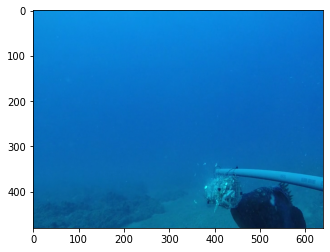

In [ ]:
import torchvision

# Load video
video, audio, metadata = torchvision.io.read_video(video_path, start_sec, end_sec, pts_unit='sec', output_format = 'TCHW') #files are big because they are tensors and not compressed videos anymore
video.to(DEVICE)
print(video.size())
plt.imshow(video[10].permute(1,2,0).cpu())
plt.show()

In [ ]:
nframes=video.size()[0]
video=video[int(nframes/2-10):int(nframes/2+10)] # Only take 20 central frames
print('original video size',video.size())
video1=torch.permute(video, (0,3,1,2))
print('yolo input video size:', video1.size())
# video1=video1.numpy()
results = model(video)
print('results size',results.size()) # something is off because the resuls has weird size
# so trying to understand how to load data differently. Maybe making my own dataloader?
# https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

original video size torch.Size([20, 3, 480, 640])
yolo input video size: torch.Size([20, 640, 3, 480])
results size torch.Size([20, 18900, 85])


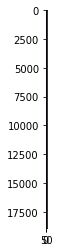

In [ ]:
plt.imshow(results[0].cpu())
plt.show()

### load video method 2 (crashes)

In [ ]:
import json
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from typing import Dict

In [ ]:
#video_path, start_S
# Initialize an EncodedVideo helper class
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
# video_data = transform(video_data)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]